In this example we will perform an analysis for the app focusing on investigation why people remove app. Our negative target even in this case will be "app_remove".

In [ ]:
!pip install tqdm

In [14]:
from retentioneering import init_config
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

init_config(
    experiments_folder='mobile-app', # folder for saving experiment results: graph visualization, heatmaps and etc.
    index_col='user_pseudo_id', # column by which we split users / sessions / whatever
    event_col='event_name', # column that describes event
    event_time_col='event_timestamp', # column that describes timestamp of event
    positive_target_event='not_remove', # name of positive target event
    pos_target_definition={},
    negative_target_event='app_remove', # name of positive target event
)

In [2]:
data = pd.read_csv('data/mobile-app-data.zip')
data = data.sort_values('event_timestamp')
# adds positive event
data = data.retention.prepare()

In [3]:
print('data.shape', data.shape)
print('data.user_pseudo_id.nunique()', data.user_pseudo_id.nunique())

data.shape (4752721, 3)
data.user_pseudo_id.nunique() 28818


Firstly, we need to filter and aggregate events.

To remove specific event simply click on the blue checkbox for selected event. To aggregare group of events to single parent event click on the smaller gray checkbox near parent event.

Now let's remove system events, screen_view, os events, user_engagement, from app we need just app_remove, 

In [4]:
data.retention.show_tree_selector()

After that you need to download created filter with using "Download Filter" link.

Now you can use this filter using next chunk.

Below you can upload filter file we created for the cases we illustrate later in this notebook

In [5]:
data = data.retention.use_tree_filter('filter_list.json')

Lets split data into sessions

In [6]:
data.retention.split_sessions(by_event='session_start')
data['user_session'] = data.user_pseudo_id + data.session.astype(int).astype(str)

# Analysis

## Step matrix

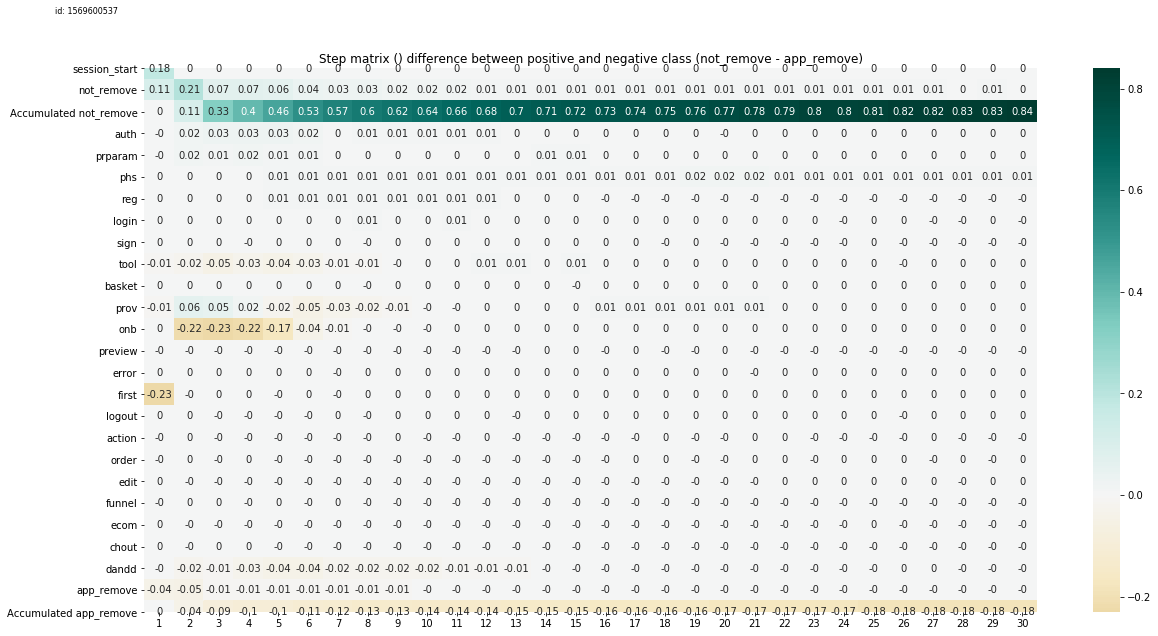

In [7]:
f = data.retention.create_filter(index_col='user_session')
data.retention.get_step_matrix_difference(f, index_col='user_session');

From previous plot we can see that in sessions with removed app, users significantly slows down on onboarding (onb group) and on catalogue (prov group).

This is our first hypothesis about app problems.

## Clustering

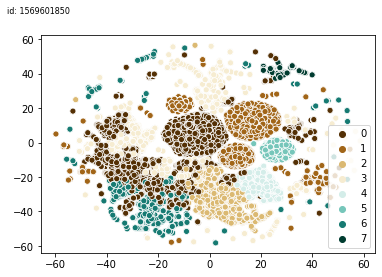

In [9]:
data.retention.learn_tsne(index_col='user_session', plot_type='clusters');

We can choose cluster from center and visualize it

We can see problems with catalogue for zero cluster: a lot of users move from app after first prov event.

In [10]:
data.retention.get_clusters(index_col='user_session');

In [11]:
(data
 .retention
 .filter_cluster(1, index_col='user_session')
 .retention
 .plot_graph(index_col='user_session', thresh=0.05))

/home/adam/.local/lib/python3.6/site-packages/networkx/drawing/layout.py:923: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



'mobile-app/index_2019-09-27 16_31_08_870544.html'

Selection process involves multiple steps were users edit their selected products and select different kind of options (node "param"). Users can do this without authorization. But after they add selected and customized products to cart they are asked to authorize.

In this cluster we can clearly see the problem with autorization: after authorization we need to return to catalogue (node "prov") and start selection and customization process all over again (node "prparam").

We can see from graph that there is no way to return after authorization to previous step in catalogue (no edge from "auth" to "prparam").

This is a problem in app: authorization brokes user trajectory, so user should return in the beginning.

We can see problems with detailed events via `dump_event_col` column.

In [12]:
(data
 .retention
 .filter_cluster(1, index_col='user_session')
 .retention
 .plot_graph(index_col='user_session', cols=['dump_event_col', 'dump_event_col_shift'], thresh=0.08, width=800, height=800))

'mobile-app/index_2019-09-27 16_31_09_151579.html'

This graph can support our hypothesis about bad catalogue organization with `prov_click_category_other` event. We can see that users often remove app after this event, wich redirects users to web-page. It's clear example of not optimal app organization where web-page link cannibiling users from mobile app.

# Predict app remove

## Посмотрим как влияет количество event-в до конца на качество работы модели

### На train-test split

In [7]:
#train test split
data_train , data_test = data.retention.index_based_split(index_col='user_pseudo_id')

In [8]:
# select group of users with trajectories longer > 20
min_length = 20

users_grouped = data.groupby('user_pseudo_id').size()

good_users_list = users_grouped[users_grouped > min_length].index.tolist()

#keep only users with trajectories longer than min_length
data_test_clean = data_test[data_test.user_pseudo_id.isin(good_users_list)]
data_train_clean = data_train[data_train.user_pseudo_id.isin(good_users_list)]

In [38]:
# Сreate model on train
res_matrix = {}
# wo_last_k  - убирает последник к event-ов
# last_k     - берет последние к eventov  wo_last_k<last_k

for last_k in tqdm(range(0, 10)):
    for wo_last_k in tqdm(range(0, last_k)):
        # Обучаем модель
        model = data_train_clean.retention.create_model(wo_last_k = wo_last_k,
                                                        last_k = last_k)  
        m = model.show_quality_raw(data_test_clean)
        res_matrix[(last_k, wo_last_k)] = {'ROC-AUC' : m[0],
                                           'Average Precision' : m[1],
                                           'Accuracy' : m[2]}


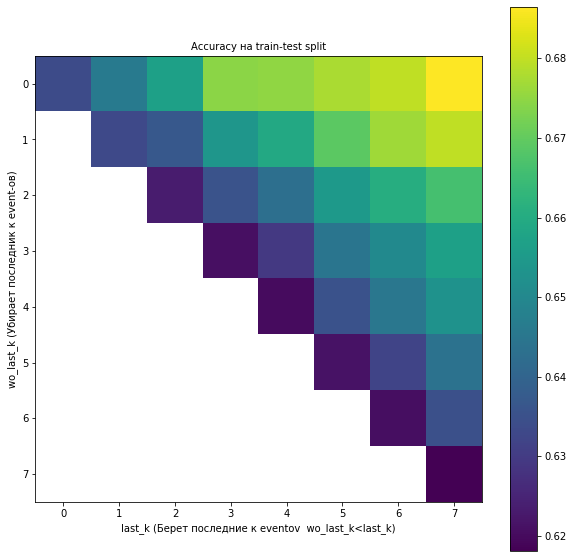

In [18]:
metric_name = 'Accuracy'
df_results = {}
for (k,v), val in res_matrix.items():
    if k not in df_results:
        df_results[k] = {}
        
    df_results[k][v] = val[metric_name]
    
df_results = pd.DataFrame(df_results)

from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize = (10, 10))
plt.title('Accuracy на train-test split', fontsize = 10)
plt.imshow(df_results)
plt.ylabel('wo_last_k (Убирает последник к event-ов)', fontsize = 10)
plt.xlabel('last_k (Берет последние к eventov  wo_last_k<last_k)', fontsize = 10)
plt.colorbar()

In [23]:
df_results

,2,3,4,5,6,7,8,9
1,0.633688,0.646361,0.656991,0.674571,0.674980,0.677841,0.679886,0.686427
2,NaN,0.633279,0.636958,0.654129,0.659444,0.669256,0.676615,0.679886
3,NaN,NaN,0.623467,0.635732,0.643091,0.654947,0.660670,0.666394
4,NaN,NaN,NaN,0.621014,0.629599,0.644726,0.650450,0.656991
5,NaN,NaN,NaN,NaN,0.620196,0.635323,0.645135,0.652903
6,NaN,NaN,NaN,NaN,NaN,0.621423,0.632052,0.643908
7,NaN,NaN,NaN,NaN,NaN,NaN,0.620605,0.634914
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.618152


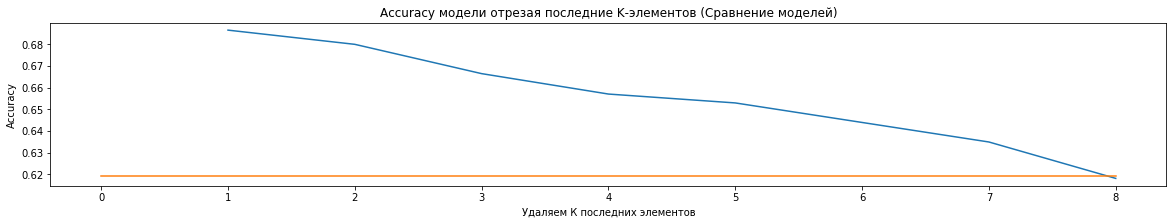

In [35]:
y_list = df_results[9]
x_list = list(df_results.index)

plt.figure(figsize = (20, 3))
plt.title('%s модели отрезая последние K-элементов (Сравнение моделей)'%metric_name)

plt.plot(x_list, y_list)
mean_target = model.target.mean()
plt.plot( [0, max(df_results.index)], [mean_target, mean_target], label = 'All 1 prediction')

plt.ylabel('%s'%metric_name)
plt.xlabel('Удаляем К последних элементов')
plt.show()


### (Сложно) На 4-фолдовой кросс-валидации для трех Логистических регрессий C = 1e-2, 1e0, 1e2

In [37]:
# # create model on train
from sklearn.linear_model import LogisticRegressionCV
from tqdm import tqdm
res_matrix = {}
# wo_last_k  - убирает последник к event-ов
# last_k     - берет последние к eventov  wo_last_k<last_k

for last_k in tqdm(range(1, 10)):
    for wo_last_k in tqdm(range(1, last_k)):
        model = data.retention.create_model(wo_last_k = wo_last_k,
                                            last_k = last_k,
                                            model_type = LogisticRegressionCV,
                                            Cs = [0.01, 1, 100],
                                            cv = 4,
                                            tol = 1e-4,
                                            max_iter = 500,
                                            scoring='accuracy')

        res_matrix[(last_k, wo_last_k)] = model.mod.scores_

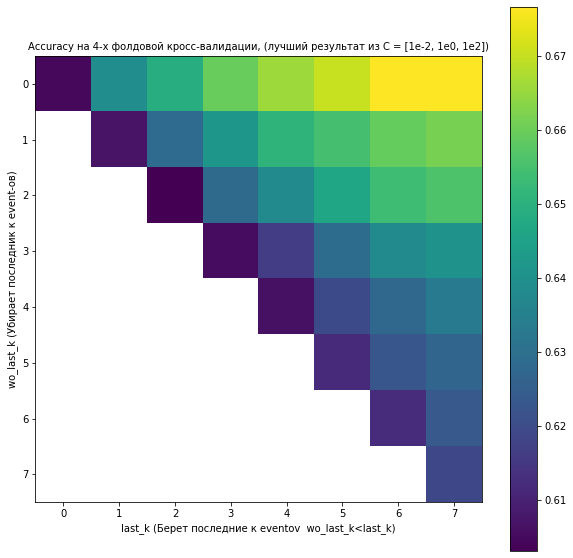

In [16]:
df_results = {}
for (k,v), val in res_matrix.items():
    if k not in df_results:
        df_results[k] = {}
        
    df_results[k][v] = max(val[True].mean(axis = 0))
    
df_results = pd.DataFrame(df_results)

from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize = (10, 10))
plt.title('Accuracy на 4-х фолдовой кросс-валидации, (лучший результат из C = [1e-2, 1e0, 1e2])', fontsize = 10)
plt.imshow(df_results)
plt.ylabel('wo_last_k (Убирает последник к event-ов)', fontsize = 10)
plt.xlabel('last_k (Берет последние к eventov  wo_last_k<last_k)', fontsize = 10)
plt.colorbar()

In [17]:
## Добавляем пустые собатия, чтобы не разалилось 
user_list = data.user_pseudo_id.unique()
time_min = data['event_timestamp'].min()
data_pref = [{"user_pseudo_id" : UID,
             "event_timestamp" : time_min,
             "event_name": 'empty'} for UID in user_list]*120
data_pref = pd.DataFrame(data_pref)

In [18]:
data_with_sleeps = pd.concat([data_pref, data])

/home/adam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [19]:
# # create model on train
from sklearn.linear_model import LogisticRegressionCV
from tqdm import tqdm
res_last = {}
# wo_last_k - Убирает последник к event-ов
# last_k    = Берет последние к eventov  wo_last_k<last_k

for wo_last_k in tqdm(list(range(0, 20))+[50, 100]):
        #for wo_last_k in tqdm(range(1, last_k)):
        model = data_with_sleeps.retention.create_model(wo_last_k = wo_last_k,
                                            model_type = LogisticRegressionCV,
                                            Cs = [0.01, 1, 100],
                                            cv = 4,
                                            tol = 1e-4,
                                            max_iter = 1000,
                                            scoring='accuracy')


        res_last[wo_last_k] = model.mod.scores_

100%|██████████| 22/22 [12:47<00:00, 34.91s/it]


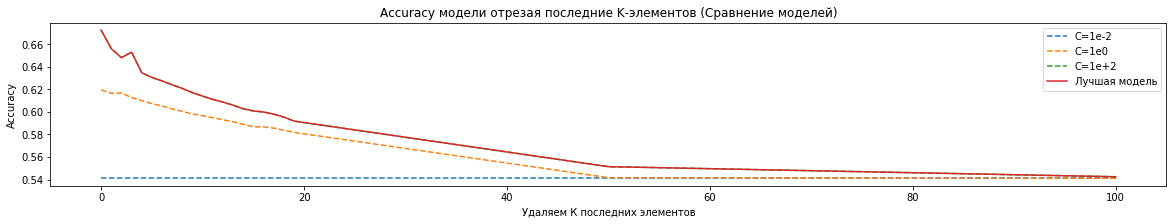

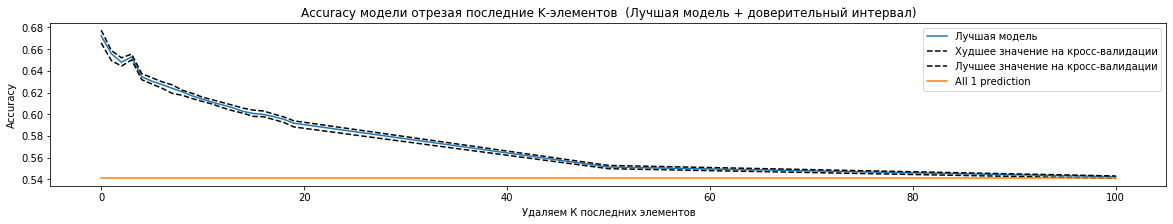

In [22]:
results = {}
for x, o in res_last.items():
    results[x] = {'1e-2' : o[True][:, 0], 
                  '1e0'  : o[True][:, 1], 
                  '1e+2' : o[True][:, 2],
                  'best' : o[True][:, np.argmax(o[True].mean(axis = 0))]
                 }
results = pd.DataFrame(results).T

plt.figure(figsize = (20, 3))
plt.title('Accuracy модели отрезая последние K-элементов (Сравнение моделей)')

for name in ['1e-2', '1e0', '1e+2']:
    plt.plot(results.index, results[name].apply(np.mean),'--', label = "C=%s"%name)

plt.plot(results.index, results['best'].apply(np.mean), label = "Лучшая модель")

plt.ylabel('Accuracy')
plt.xlabel('Удаляем К последних элементов')
plt.legend()
plt.show()

plt.figure(figsize = (20, 3))
plt.title('Accuracy модели отрезая последние K-элементов  (Лучшая модель + доверительный интервал)')


plt.plot(results.index, results['best'].apply(np.mean), label = "Лучшая модель")
plt.plot(results.index, results['best'].apply(np.min), '--', color = 'black', label = "Худшее значение на кросс-валидации")
plt.plot(results.index, results['best'].apply(np.max), '--', color = 'black', label = "Лучшее значение на кросс-валидации")
mean_target = model.target.mean()
plt.plot( [0, max(results.index)], [mean_target, mean_target], label = 'All 1 prediction')
plt.ylabel('Accuracy')
plt.xlabel('Удаляем К последних элементов')
plt.legend()
plt.show()
